# Fine-Tuning RoBERTa on Zoning By-laws

### Introduction

Zoning By-laws contain important information about land use, building height, density, and other development regulations. They are important documents that inform urban planning and development decisions in cities.

They are often stored as long, unstructured PDF legal documents and it's difficult to find information within them. Zoning information is also spatial and tied to geospatial datasets. It would be great if the zoning information in the by-laws could be extracted in an efficient and automated way and joined with geospatial datasets.

**This experiement aims to fine-tune a pre-trained RoBERTa QA model to increase its accuracy in extracting information from Zoning By-laws.**

### Why RoBERTa?

[RoBERTa](https://huggingface.co/docs/transformers/en/model_doc/roberta) is an optimized version of BERT and improves it with new pretraining objectives.  The pretraining objectives include dynamic masking, sentence packing, larger batches and a byte-level BPE tokenizer. Since it is a newer improved model it is generally considered to outperform BERT on NLP tasks. In this experiment a fine-tuned version on SQuAD 2 used for question answering called [roberta-base-squad2 or roberta-base for Extractive QA](https://huggingface.co/deepset/roberta-base-squad2) is used.

[roberta-base-squad2 or roberta-base for Extractive QA](https://huggingface.co/deepset/roberta-base-squad2) is chosen because in the [Zeroshot QA Experiments](https://github.com/JoT8ng/zoning-extraction-pipelines/blob/main/zeroshot_qa/zeroshot_qa_experiment2.ipynb) it outperformed [DistilBERT](https://huggingface.co/docs/transformers/en/model_doc/distilbert) in terms of accuracy.

For more info on NLP, LLMs, and transformer models:
[Hugging Face LLM Course](https://huggingface.co/learn/llm-course/en/chapter1/2)

### Fine-Tuning Strategy

The fine-tuning strategy chosen for this experiment is based on a paper called ["Fine-tuning Strategies for Domain Specific Question Answering under Low Annotation Budget Constraints"](https://arxiv.org/html/2401.09168v1).

The paper acknowledges the challenge and cost of adapting foundation models to specific tasks due to the huge amount of annotated samples required to fine-tune those models. In reality, training datasets for domain specific tasks are small due to budget constraints and creating a dataset with hundreds of labelled examples is tedious. 

The paper highlights that tradtionally this issue is circumvented using a double fine-tuning step:

*"It consists of fine-tuning the pre-trained foundation model on a large-scale training dataset that is as close as possible (domain and objective) to the target task and is then further fine-tuned on the given domain/task for which training data is scarce. The result is a Pre-trained Language Model (PLM) like BERT [1], trained on masked language modeling or text generation task, that is then fine-tuned on a more specific large-scale task (LM’), and ultimately refined on the domain/task at hand (LM’’)...*

*In the double fine-tuning step stated above, practitioners usually leverage the Stanford Question Answering Dataset (SQuAD) [10] which is a high-quality QA dataset that covers diverse knowledge for the PLM to train on. Nonetheless, in many real-life scenarios, specific-domain QA has a range of field applications that is narrower than SQuAD and may not appear in the SQuAD training data. This calls for building a domain-specific dataset to further fine-tune a QA model for the domain at hand to produce a QA model LM’’. This last fine-tuning step is domain-dependent, and the practitioner’s goal is also to ultimately keep the number of annotated training samples low - they are under a low annotation budget constraint. It’s worth mentioning that, for extractive QA, annotating 200 examples is already a time-consuming work: the collection of question and answer data requires the annotator to read and understand the text in order to ensure the reasonableness of the marked answers."*(Smith & Doe, 2024)

The paper concludes that the **best strategy to fine-tune a QA model on low-budget settings is taking a pre-trained model and fine-tuning it with a dataset composed of the target domain dataset and the SQuAD dataset.** This is the strategy that will be used in this experiment.

### About the training dataset

A dataset of 200 labeled examples for training and 50 labeled examples for validation was created to use in this experiment. The dataset was created manually from a range of different zoning by-laws from different municipalities across Canada in an Excel document and exported into CSV format. The CSV format is deemed appropriate for this experiment because training dataset is small and simple. [More information on LLM dataset formats](https://huggingface.co/blog/tegridydev/llm-dataset-formats-101-hugging-face)

The municipalities whose Zoning By-laws are used for the training dataset:

* Toronto
* Calgary
* Edmonton
* Vancouver
* Waterloo
* Saint John
* Surrey
* Burnaby
* City of Langley
* Halifax
* Niagara Falls
* Maple Ridge

To really test the efficacy of the models in extracting the zoning information, a range of different questions and contexts from different zoning by-laws throughout Canada are used. Some of the contexts are a mix of messy and clean snippets from the zoning by-law. Some contexts contain a longer snippet of raw text directly extracted from the by-law to optimize how the model understands local context within a larger relevant document. Training with longer truncated inputs provides better contextual representations.

As mentioned above, the fine-tuning strategy involves using a training dataset composed of the target domain dataset and the SQuAD dataset. 150 examples consist of labeled examples from various Zoning By-laws and 50 examples are from the [SQuAD 2.0 dataset](https://rajpurkar.github.io/SQuAD-explorer/).

The Hugging Face Datasets library is not used in this experiment because it is not necessary. This is a small experiment and advanced features from the Datasets library (shuffling, splitting, streaming, or pushing to the Hugging Face Hub) are not required.

### Imports and Set Up

First, import all the necessary Python libraries. The Hugging Face Transformers Library is used.

Since this is a small and simple training dataset, an auto tokenizer is used as it is not deemed necessary to manually customize the tokenization process.

In [1]:
from transformers import AutoTokenizer, RobertaForQuestionAnswering, TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

### Data Preprocessing

[More information on QA data processing](https://huggingface.co/learn/llm-course/en/chapter7/7)

In [2]:
# Load CSV training dataset
dataset = load_dataset(
    "csv",
    data_files={
        "train": "TrainingDataset.csv",
        "validation": "ValidationDataset.csv"
    }
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast = True)

max_length = 512 # maximum number of tokens the model can take as input. For RoBERTa it's 512
stride = 128 # When truncating long contexts, stride lets you create a sliding window over the text so overlapping chunks are created

# Tokenize function
def tokenize_function(examples):

    # Tokenize questions and contexts
    inputs = tokenizer(
        examples["question"],
        examples["context"],
        truncation = "only_second", # Truncation = True will truncate if it exceeds max length. "only_second" will truncate only at the second sequence, which is the context
        max_length = max_length,
        stride = stride,
        return_overflowing_tokens = True, # returns extra chunks from stride
        return_offsets_mapping = True, # returns a mapping from token positions to character positions in the original text. Can find the start/end of character positions of the answer in context
        padding = "max_length"
    )

    # Convert "ground_truth" to start/end positions
    # In extractive QA, the model is not trained to generate the answer text directly but it learns to predict start token index and end token index inside the given context
    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer_text = str(examples["ground_truth"][sample_idx])
        context = examples["context"][sample_idx]

        cls_index = inputs["input_ids"][i].index(tokenizer.cls_token_id)

        # Find character start/end of the answer in the context
        start_char = context.find(answer_text)
        if start_char == -1:
            # If answer not found, set to CLS token (special classification token that represents no answer)
            start_positions.append(cls_index)
            end_positions.append(cls_index)
            continue
        end_char = start_char + len(answer_text)

        # Sequence IDs: 0 = question, 1 = context, None = special tokens
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context in token space
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while idx < len(sequence_ids) and sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context chunk, set CLS
        if offsets[context_start][0] > start_char or offsets[context_end][1] < end_char:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            # Otherwise it's the start and end token positions
            # Find start token index
            token_start_index = context_start
            while token_start_index <= context_end and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)

            # Find end token index
            token_end_index = context_end
            while token_end_index >= context_start and offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    # Store positions in inputs
    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    # Dataset is ready for fine-tuning
    # Contains: input_ids, attention_mask, start_positions_, end_positions
    return inputs

# Apply preprocessing
tokenized_datasets = dataset.map(tokenize_function, batched = True, remove_columns = dataset["train"].column_names)

# Check data preprocessing for training and validation datasets with first 3 samples
for idx in range(3):  # first 3 samples
    sample = tokenized_datasets["train"][idx]
    print(f"Sample {idx}")
    print("Question:", dataset["train"][idx]["question"])
    print("Context:", dataset["train"][idx]["context"])
    print("Ground Truth:", dataset["train"][idx]["ground_truth"])
    print("Start Position:", sample["start_positions"])
    print("End Position:", sample["end_positions"])
    print("Decoded Answer:", tokenizer.decode(sample["input_ids"][sample["start_positions"]:sample["end_positions"]+1]))
    vsample = tokenized_datasets["validation"][idx]
    print(f"Validation Sample {idx}")
    print("Question:", dataset["validation"][idx]["question"])
    print("Context:", dataset["validation"][idx]["context"])
    print("Ground Truth:", dataset["validation"][idx]["ground_truth"])
    print("Start Position:", vsample["start_positions"])
    print("End Position:", vsample["end_positions"])
    print("Decoded Answer:", tokenizer.decode(vsample["input_ids"][vsample["start_positions"]:vsample["end_positions"]+1]))

Sample 0
Question: What is the maximum building depth?
Context: The maximum building depth of a Contextual Semi-detached Dwelling is the greater of: A 60.0 per cent of the parcel depth; or B the contextual building depth average.
Ground Truth: 60.0 per cent of the parcel depth; or B the contextual building depth average.
Start Position: 30
End Position: 47
Decoded Answer:  60.0 per cent of the parcel depth; or B the contextual building depth average.
Validation Sample 0
Question: What is the minimum setback?
Context: Minimum Setback for portions of Towers greater than 23.0 m in Height from an Abutting Street: 6.0 m
Ground Truth: 6.0 m
Start Position: 31
End Position: 34
Decoded Answer:  6.0 m
Sample 1
Question: What is the maximum building depth for a Contextual Single Detached Dwelling located on a parcel width greather than 10 metres?
Context: The maximum building depth of a Contextual Semi-detached Dwelling is the greater of: A 60.0 per cent of the parcel depth; or B the contextual 

### Fine-Tune the Model

Since the training dataset is small, I have decided to train the model with 5 epochs. A failsafe "early stopping callback with patience" is added in the code so that if the model starts showing signs of overfitting during training it will stop after 2 epochs. Early stopping is a technique that monitors a metric during training and stops when the metric stops improving after a certain number of evaluation steps to prevent overfitting and save compute time.

The learning rate is set to a slower "2e-5" to prevent overfitting of the model because of the small dataset. [More information on learning rates](https://www.ibm.com/think/topics/learning-rate#:~:text=Learning%20rate%20is%20important%20because,small%20that%20learning%20is%20inefficient.)

In [3]:
# Load model
model = RobertaForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")

# Training arguments
training_args = TrainingArguments(
    output_dir = "./roberta-qa",
    eval_strategy = "epoch",
    learning_rate = 1e-5,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    num_train_epochs = 3,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    greater_is_better = False,
    logging_dir = "./logs",
    logging_steps = 10,
    save_strategy = "epoch",
    dataloader_pin_memory=False
)

# Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    processing_class = tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience = 2)]
)

# Train
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.018000,0.879664
2,0.579700,1.030443
3,0.296300,1.012462


TrainOutput(global_step=216, training_loss=0.9463095753281204, metrics={'train_runtime': 1130.735, 'train_samples_per_second': 0.764, 'train_steps_per_second': 0.191, 'total_flos': 225760397819904.0, 'train_loss': 0.9463095753281204, 'epoch': 3.0})

### Understanding Learning Curves

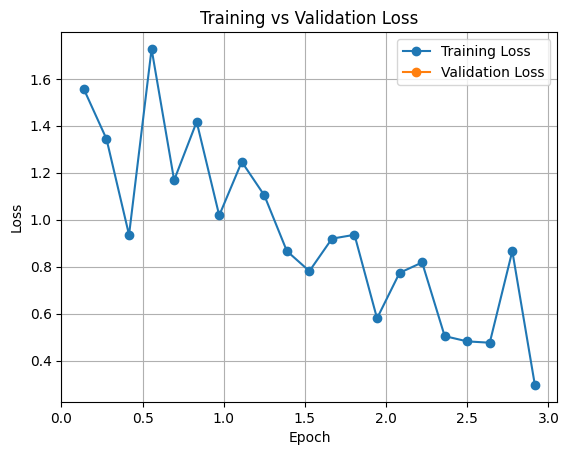

In [7]:
# Plot training metrics
logs = pd.DataFrame(trainer.state.log_history)
train_logs = logs[logs["loss"].notna()]
eval_logs = logs[logs["eval_loss"].notna()]
plt.plot(train_logs["epoch"], train_logs["loss"], marker = "o", label = "Training Loss")
plt.plot(eval_logs["epoch"], eval_logs["loss"], marker = "o", label = "Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Save model
trainer.save_model("./roberta-zoning-qa-finetuned1")